In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os.path as op
import pandas as pd
from mriqc.viz.misc import raters_variability_plot, plot_abide_stripplots, plot_corrmat, plot_histograms

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data_path = '/home/oesteban/Google Drive/mriqc'
x_path = op.join(data_path, 'aMRIQC_abide_20161130.csv')
# y_path = op.join(data_path, 'ABIDE_QC_Marie.csv')
y_path = op.join(data_path, 'ABIDE_QC_all.csv')

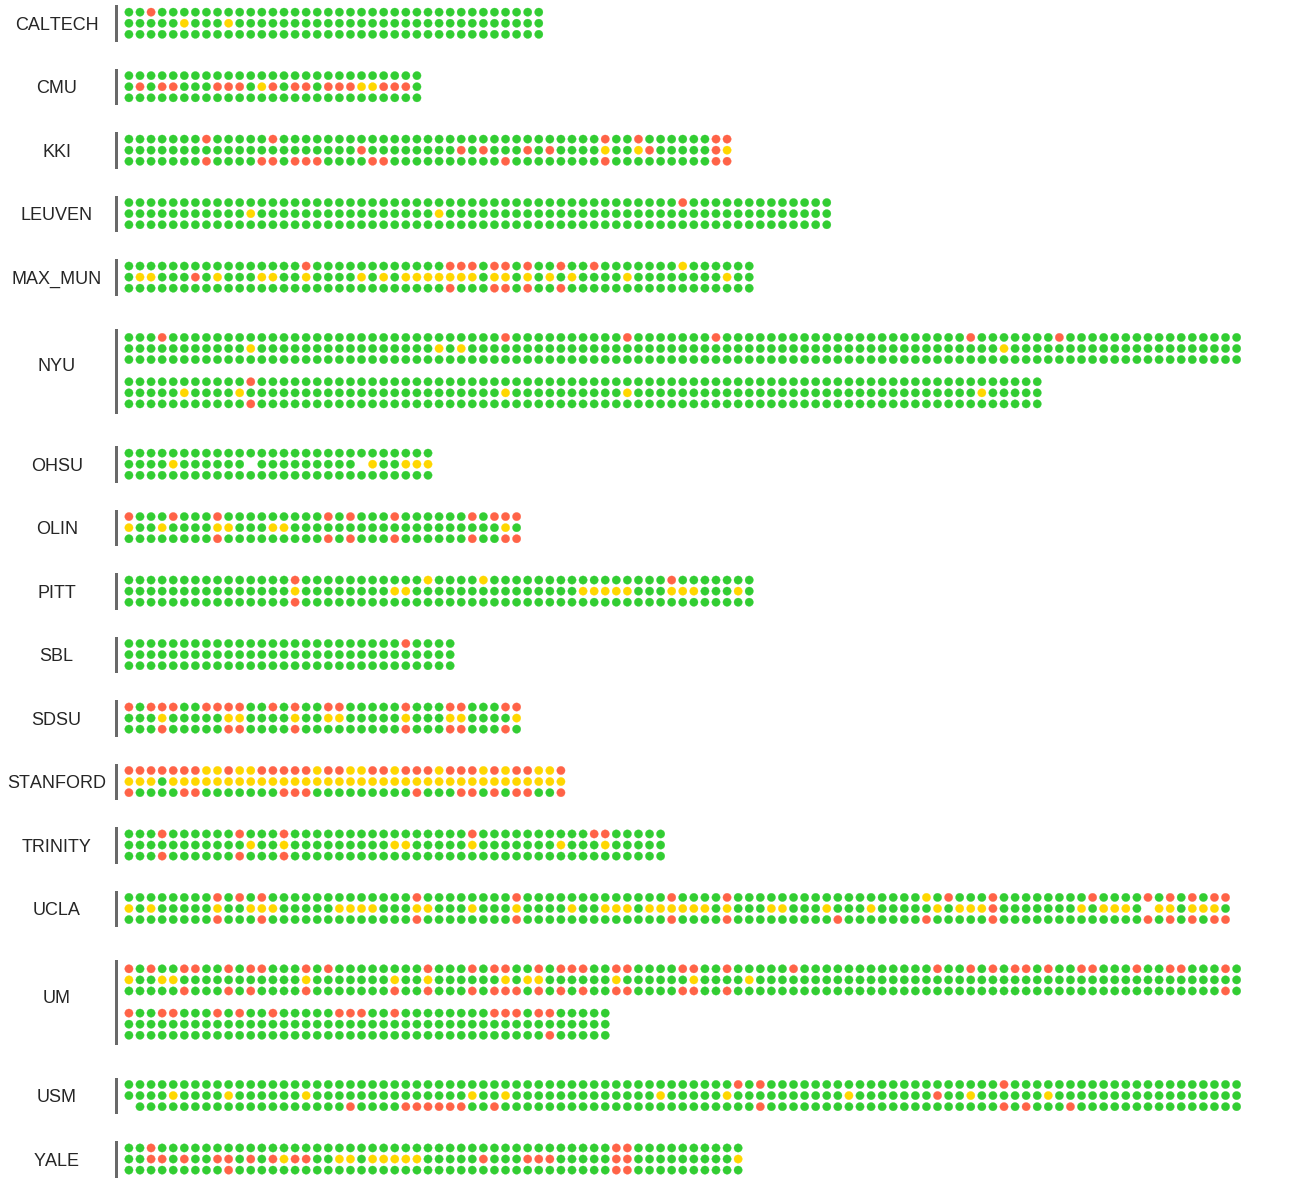

In [4]:
fig = raters_variability_plot(y_path)

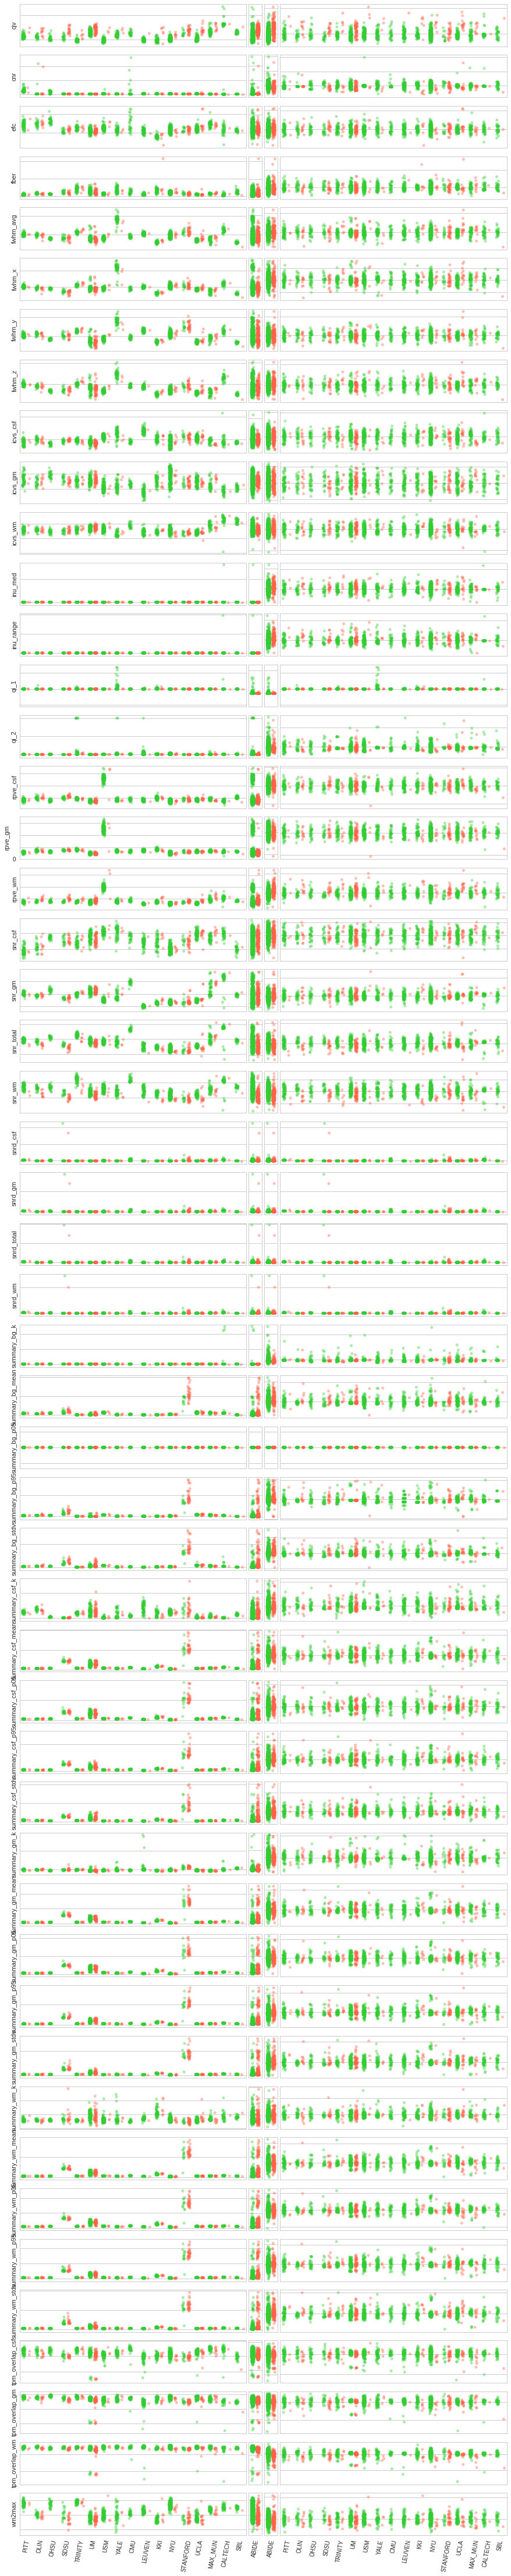

In [17]:
fig = plot_abide_stripplots(x_path, y_path)

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


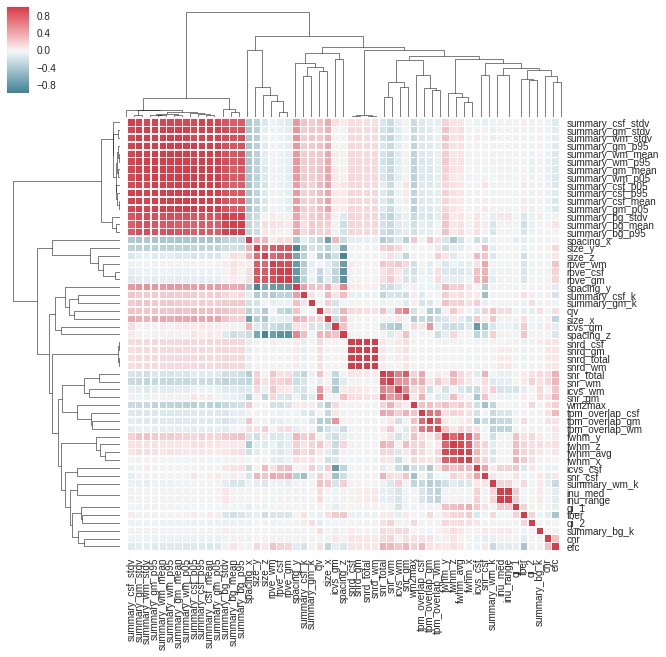

In [6]:
fig = plot_corrmat(x_path)

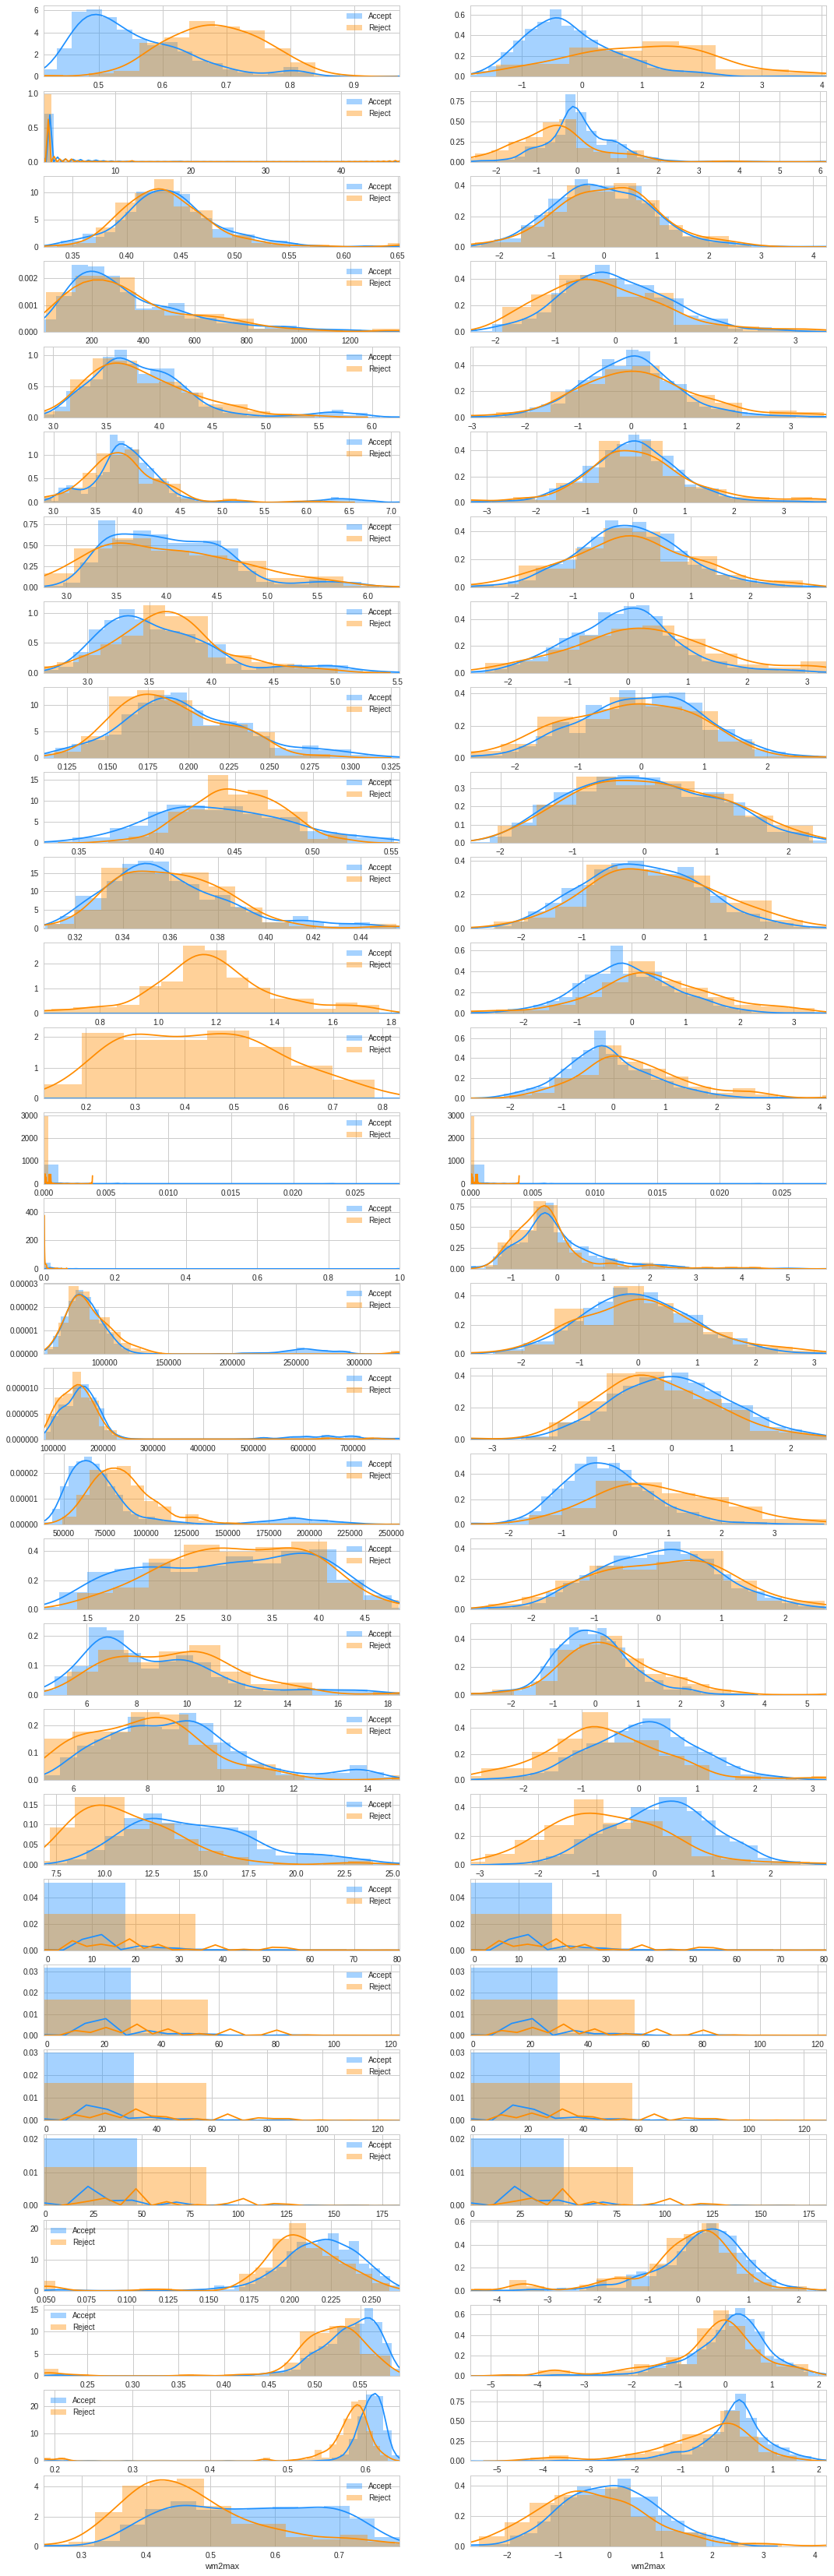

In [18]:
fig = plot_histograms(x_path, y_path)

In [20]:
import os.path as op
import pandas as pd
import numpy as np
data_path = '/home/oesteban/Google Drive/mriqc'
loso = pd.read_csv(op.join(data_path, 'cv_loso_wtaskid.csv'), index_col=False, na_values='n/a', na_filter=False)
kfold = pd.read_csv(op.join(data_path, 'cv_10fold_wtaskid.csv'), index_col=False, na_values='n/a', na_filter=False)

def gen_newparams(dataframe):
    thisdf = dataframe.copy()
    thisdf['zscored_str'] = ['nzs'] * len(thisdf['zscored'])
    thisdf.loc[thisdf.zscored == 1, 'zscored_str'] = 'zs'
    thisdf['params'] = thisdf['clf'] + '-' + thisdf['zscored_str'] + ' ' + thisdf['params']
    del thisdf['zscored_str']
    return thisdf

In [21]:
loso = gen_newparams(loso)
kfold = gen_newparams(kfold)

In [23]:
loso_models_list = list(set(loso.params.values.ravel().tolist()))
kfold_models_list = list(set(kfold.params.values.ravel().tolist()))

In [24]:
loso_rfc_nzs = loso.loc[loso.params.str.contains('rfc-nzs')]

max_auc = loso_rfc_nzs.mean_auc.max()
best_loso_rfc_nzs = loso_rfc_nzs.loc[loso_rfc_nzs.mean_auc >= max_auc]
print max_auc
best_loso_rfc_nzs.params.values.ravel()

0.926854754441


array([ "rfc-nzs {'min_samples_split': 2, 'n_estimators': 200, 'max_depth': None}",
       "rfc-nzs {'min_samples_split': 2, 'n_estimators': 50, 'max_depth': 20}"], dtype=object)

In [26]:
best_param = {}

spstr = ['LoSo', '10-fold']
best_models = {}
for i, split_cv in enumerate([loso, kfold]):
    best_models[spstr[i]] = {}
    splitcols = [col for col in split_cv.columns.ravel() if col.startswith('split0')]
    for clf in ['svc_linear-nzs', 'svc_rbf-nzs', 'rfc-nzs', 'svc_linear-zs', 'svc_rbf-zs', 'rfc-zs']:
        thismodeldf = split_cv.loc[split_cv.params.str.contains(clf)]
        max_auc = thismodeldf.mean_auc.max()
        best = thismodeldf.loc[thismodeldf.mean_auc >= max_auc]
        best_list = best.params.values.ravel().tolist()
        
        if len(best_list) == 1:
            best_models[spstr[i]][clf] = best_list[0]
        else:
            overall_means = [thismodeldf.loc[thismodeldf.params.str.contains(pset), 'mean_auc'].mean()
                             for pset in best_list]
            overall_max = np.max(overall_means)
            if sum([val >= overall_max for val in overall_means]) == 1:
                best_models[spstr[i]][clf] = best_list[np.argmax(overall_means)]
            else:
                print(clf, sum([val >= overall_max for val in overall_means]))
                best_models[spstr[i]][clf] = best_list[0]
                    
best_models



#         subcv = zscv.loc[zscv.clf.str.contains(clf)]

#         bp = list(set(subcv[['params']].values.ravel().tolist()))            
#         p_auc = []
#         for p in bp:
#             p_auc.append(maxdf.loc[subcv.params.str.contains(p), 'roc_auc'].values.mean())
#             print(maxdf.loc[subcv.params.str.contains(p), cols])

#             print np.vstack((np.average(subcv.loc[subcv.task_id == 1, splitcols], axis=1), subcv.loc[subcv.task_id == 1, 'mean_auc'])).T
        # params = list(set(subcv.params.values.ravel().tolist()))
#             print len(subcv.mean_auc.values), subcv.mean_auc.values.max()
#             max_val = subcv.mean_auc.values.max()
#             maxdf = subcv.loc[subcv.mean_auc == max_val]
#             print max_val


#             print(sp, clf, zs, len(bp), max_val, np.max(p_auc))
            

('svc_rbf-nzs', 900)
('svc_rbf-zs', 100)
('svc_rbf-nzs', 900)
('svc_linear-zs', 2)


{'10-fold': {'rfc-nzs': "rfc-nzs {'min_samples_split': 10, 'n_estimators': 100, 'max_depth': 20}",
  'rfc-zs': "rfc-zs {'min_samples_split': 2, 'n_estimators': 200, 'max_depth': None}",
  'svc_linear-nzs': "svc_linear-nzs {'C': 1}",
  'svc_linear-zs': "svc_linear-zs {'C': 0.01}",
  'svc_rbf-nzs': "svc_rbf-nzs {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.01}",
  'svc_rbf-zs': "svc_rbf-zs {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}"},
 'LoSo': {'rfc-nzs': "rfc-nzs {'min_samples_split': 2, 'n_estimators': 200, 'max_depth': None}",
  'rfc-zs': "rfc-zs {'min_samples_split': 2, 'n_estimators': 100, 'max_depth': 20}",
  'svc_linear-nzs': "svc_linear-nzs {'C': 0.01}",
  'svc_linear-zs': "svc_linear-zs {'C': 0.01}",
  'svc_rbf-nzs': "svc_rbf-nzs {'kernel': 'rbf', 'C': 0.01, 'gamma': 0.01}",
  'svc_rbf-zs': "svc_rbf-zs {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}"}}

In [ ]:
import seaborn as sn
data = cv.loc[cv.zscored == 0, ['clf', 'roc_auc', 'Split']]
ax = sn.violinplot(
    x='clf', y='roc_auc', hue='Split', data=data, split=True, inner="quart")

# ax.set_ylim([0.8, 1.1])
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Model')

In [ ]:
loso = pd.read_csv(op.join(data_path, 'loso-v2.0.csv'), index_col=False, na_values='n/a', na_filter=False)

In [ ]:
import numpy as np
loso_subset = loso[loso.zscored == 0]
params = list(set(loso_subset.params.values.ravel()))
for p in params:
    print(p, np.max(list(set(loso_subset[loso_subset.params == p].mean_auc.values.ravel().tolist()))))